In [1]:
import os
import collections

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!python -m venv coraenv

^C


In [4]:
!.\coraenv\Scripts\activate

In [12]:
# !pip install torch-geometric

  Using cached torch_geometric-2.3.1-py3-none-any.whl


You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [14]:
# !pip install networkx

  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)


You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
device

device(type='cuda')

In [8]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [9]:
dataset = Planetoid(root=data_dir, name='Cora')
dataset
data=dataset[0]

In [10]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [11]:
type(dataset)

torch_geometric.datasets.planetoid.Planetoid

In [24]:
print("Number of nodes: ", data.num_nodes)

Number of nodes:  2708


In [25]:
print("Number of nodes: ", data.num_edges)

Number of nodes:  10556


In [26]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')  # False
print(f'Has self-loops: {data.has_self_loops()}')  # False
print(f'Is undirected: {data.is_undirected()}')  # True

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [27]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [32]:
data.edge_index.numpy().shape
# edge => (u,v)
# first array is for all u
# second array id for all v

(2, 10556)

In [69]:
data.edge_index.numpy()

array([[   0,    0,    0, ..., 2707, 2707, 2707],
       [ 633, 1862, 2582, ...,  598, 1473, 2706]], dtype=int64)

In [41]:
edges = data.edge_index.numpy()

In [42]:
edges[:,np.where(edges[1]==30)]

array([[[ 697,  738, 1358, 1416, 2162, 2343]],

       [[  30,   30,   30,   30,   30,   30]]], dtype=int64)

In [52]:
sample30 = edges[:,np.where(edges[1]==2707)[0]]
sample30.flatten()

array([ 165,  598, 1473, 2706, 2707, 2707, 2707, 2707], dtype=int64)

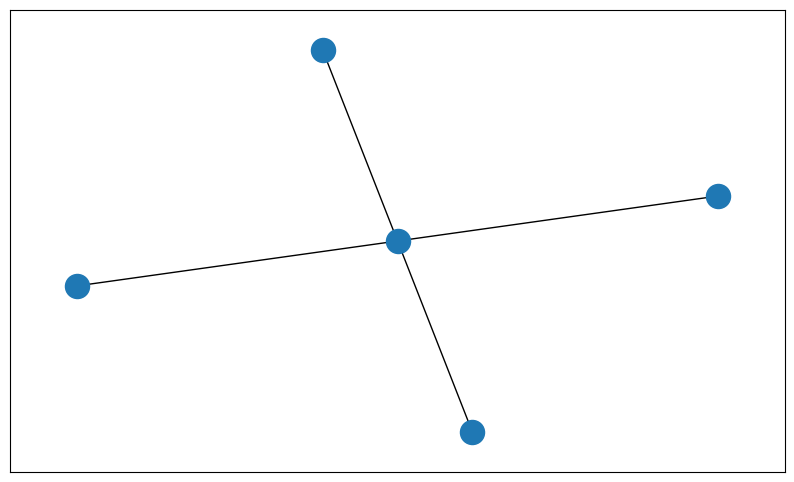

In [53]:
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(np.unique(sample30.flatten()))
G.add_edges_from(list(zip(sample30[0], sample30[1])))
nx.draw_networkx(G, with_labels=False)

In [56]:
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Average node degree: 3.90


threshold 0.011821204285186553


C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


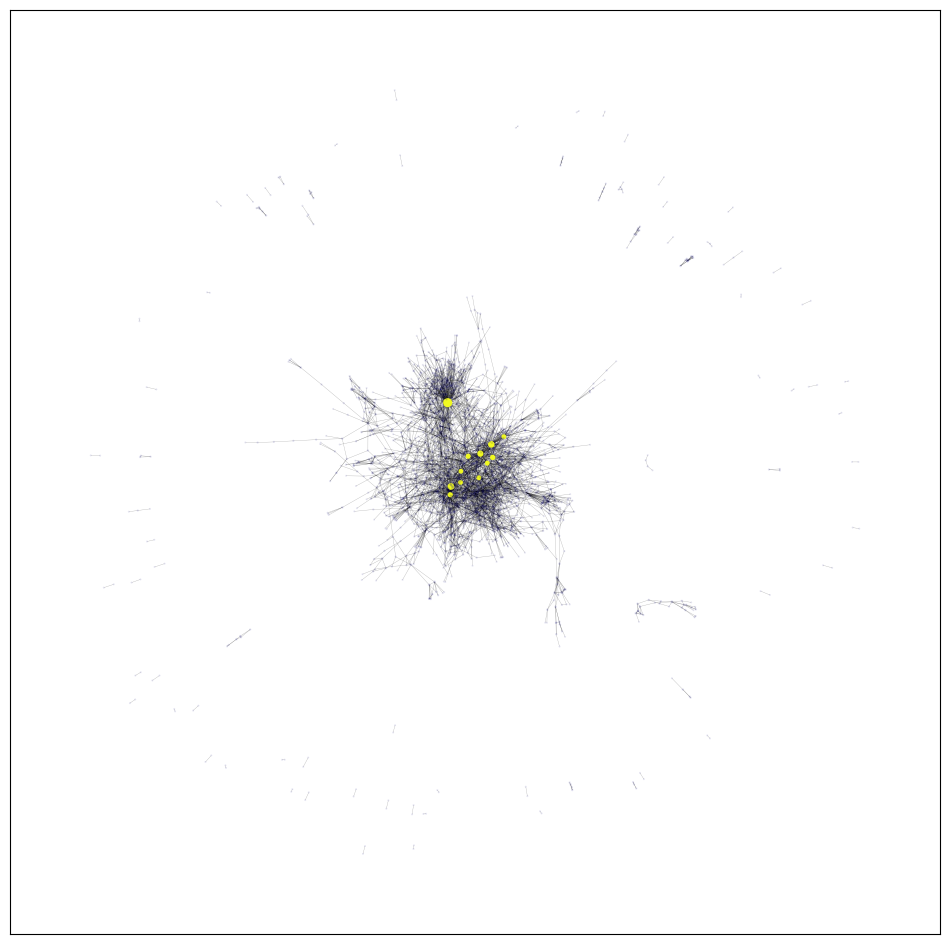

In [57]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10]
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

In [58]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1433


In [59]:
print(len(data.x[0]))
data.x[0][:20]

1433


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1.])

In [61]:
data.y[0].item()

3

In [62]:
np.unique(data.y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [63]:
label_dict = {
    0: "Theory",
    1: "Reinforcement_Learning",
    2: "Genetic_Algorithms",
    3: "Neural_Networks",
    4: "Probabilistic_Methods",
    5: "Case_Based",
    6: "Rule_Learning"}

In [65]:
counter = collections.Counter(data.y.numpy())
print(counter)
counter = dict(counter)
print(counter)

Counter({3: 818, 4: 426, 2: 418, 0: 351, 5: 298, 1: 217, 6: 180})
{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


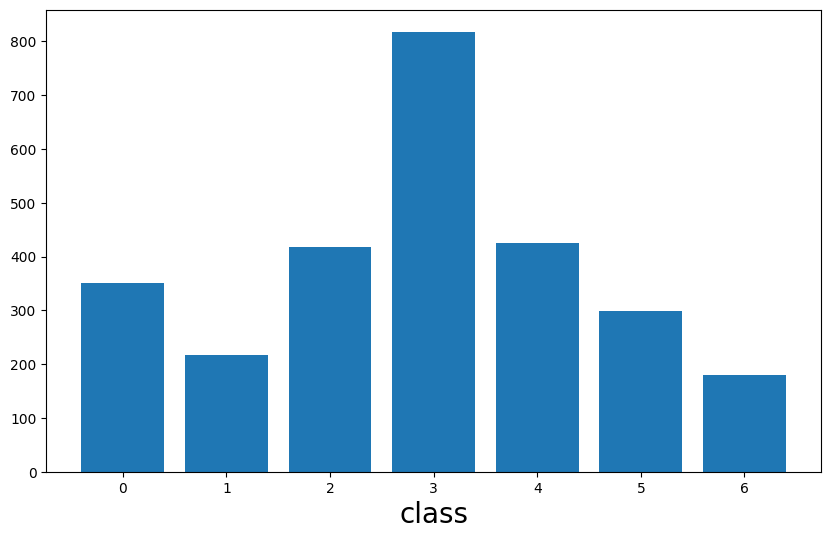

In [66]:
count = [x[1] for x in sorted(counter.items())]
plt.figure(figsize=(10, 6))
plt.bar(range(7), count)
plt.xlabel("class", size=20)
plt.show()

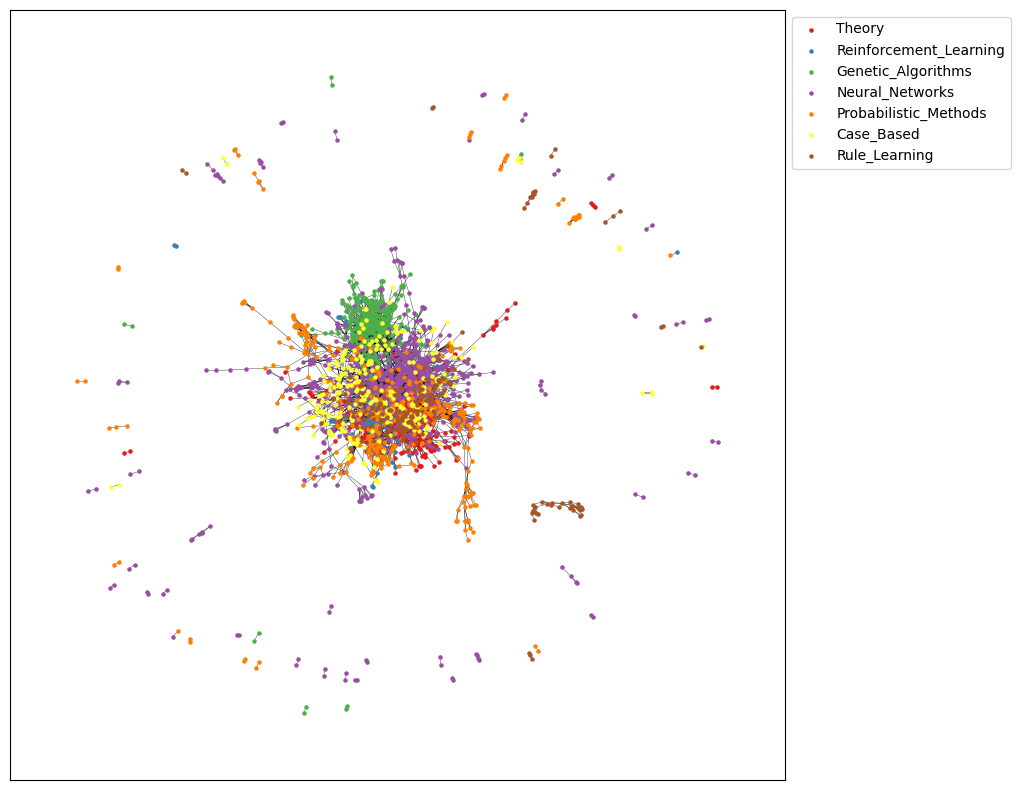

In [67]:
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
    
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(label_dict.values())
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [68]:
# For the seven classes we looked at earlier, 
# we will see how many nodes of the same class are connected by edges and vice versa.

labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set

[array([3, 3, 3, ..., 3, 3, 3], dtype=int64),
 array([3, 3, 3, ..., 3, 3, 3], dtype=int64)]

In [70]:
connected_labels_set = np.array(connected_labels_set)
connected_labels_set

array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]], dtype=int64)

In [71]:
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []

In [73]:
for i in range(7):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(f"Counts of nodes connected to {i} labelled node") 
    print(counter)
    counter = add_missing_keys(counter, range(7))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)

label: 0
1527 edges
Counts of nodes connected to 0 labelled node
{0: 1068, 1: 32, 3: 161, 6: 80, 5: 75, 4: 88, 2: 23}
label: 1
1029 edges
Counts of nodes connected to 1 labelled node
{1: 818, 3: 67, 0: 32, 5: 28, 2: 62, 4: 20, 6: 2}
label: 2
1826 edges
Counts of nodes connected to 2 labelled node
{2: 1654, 3: 53, 1: 62, 5: 30, 0: 23, 4: 2, 6: 2}
label: 3
2838 edges
Counts of nodes connected to 3 labelled node
{3: 2350, 2: 53, 4: 137, 5: 54, 0: 161, 6: 16, 1: 67}
label: 4
1592 edges
Counts of nodes connected to 4 labelled node
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
Counts of nodes connected to 5 labelled node
{2: 30, 5: 834, 0: 75, 3: 54, 1: 28, 4: 19, 6: 46}
label: 6
658 edges
Counts of nodes connected to 6 labelled node
{6: 506, 5: 46, 0: 80, 4: 6, 3: 16, 1: 2, 2: 2}


In [74]:
label_connection_counts

[[1068, 32, 23, 161, 88, 75, 80],
 [32, 818, 62, 67, 20, 28, 2],
 [23, 62, 1654, 53, 2, 30, 2],
 [161, 67, 53, 2350, 137, 54, 16],
 [88, 20, 2, 137, 1320, 19, 6],
 [75, 28, 30, 54, 19, 834, 46],
 [80, 2, 2, 16, 6, 46, 506],
 [1068, 32, 23, 161, 88, 75, 80],
 [32, 818, 62, 67, 20, 28, 2],
 [23, 62, 1654, 53, 2, 30, 2],
 [161, 67, 53, 2350, 137, 54, 16],
 [88, 20, 2, 137, 1320, 19, 6],
 [75, 28, 30, 54, 19, 834, 46],
 [80, 2, 2, 16, 6, 46, 506]]

In [75]:
label_connection_counts = np.array(label_connection_counts)


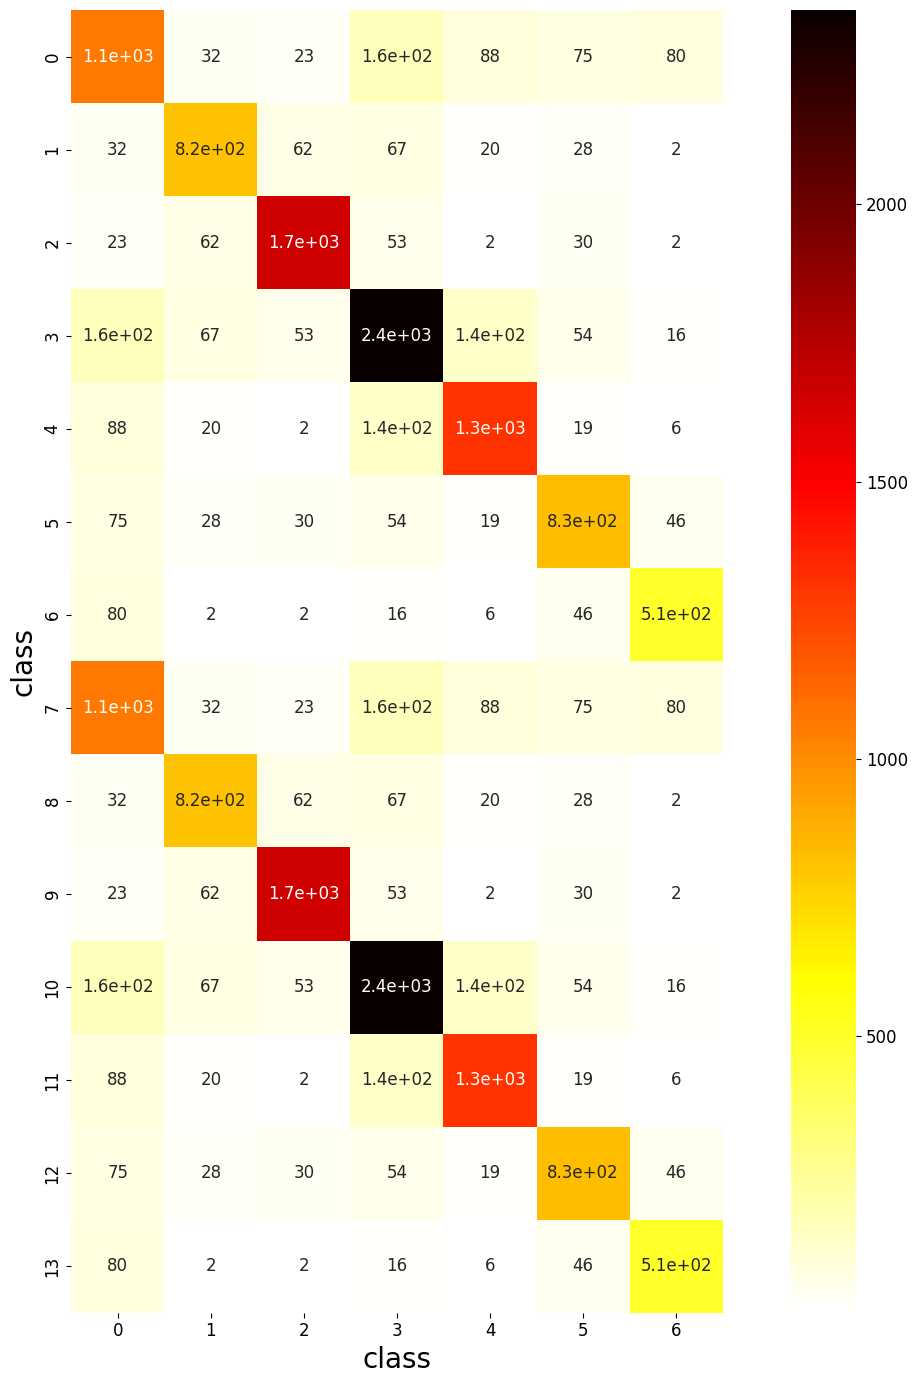

In [80]:
plt.figure(figsize=(14, 14))
plt.rcParams["font.size"] = 12
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [83]:
label_connection_counts.diagonal().sum()

8550

In [84]:
label_connection_counts.sum()

21112

In [93]:
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [92]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [15]:
dataset.num_classes

7

In [18]:
!pip install torchmetrics

     -------------------------------------- 731.6/731.6 KB 2.7 MB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\ASUS\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [19]:
import torch_geometric.transforms as T
import torch_geometric.nn.functional as F
from torch_geometric.nn import GCNConv

In [64]:
from sklearn.metrics import accuracy_score

In [20]:
# normalize rows
dataset = Planetoid(data_dir, name="Cora", transform=T.NormalizeFeatures())

In [22]:
dataset[0].x.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000])

## Building GCN

In [41]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hid_dim=16, dropout_rate=0.5):
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hid_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hid_dim, num_classes)
    
    def forward(self, x, edge_index):
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        return x

In [32]:
print(GCN)

<class '__main__.GCN'>


In [33]:
GCN(dataset.num_node_features, dataset.num_classes)

GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 16)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(16, 7)
)

In [82]:
def train_step(model, data, opt, loss_fn):
    model.train()
    opt.zero_grad()
    mask = data.train_mask
    logits = model(data.x, data.edge_index)[mask]
    # print("Logits: ", logits)
    pred = logits.argmax(dim=1)
    y = data.y[mask]
    # print("Y act:", y)
    # print("Y pred:", pred)
    loss = loss_fn(logits, y)
    acc = accuracy_score(pred.cpu(), y.cpu())
    loss.backward()
    opt.step()
    return loss.item(), acc

In [106]:
def val_step(model, data, loss_fn):
    model.eval()
    with torch.no_grad():
        mask = data.val_mask
        # print(mask)
        logits = model(data.x, data.edge_index)
        print(len(logits))
        logits = logits[mask]
        print(len(logits))
        preds = logits.argmax(dim=1)
        y = data.y[mask]
        loss = loss_fn(logits, y)
        acc = accuracy_score(preds.cpu(), y.cpu())
        return loss.item(), acc

In [107]:
EPOCHS = 200
optm = torch.optim.Optimizer
loss_fn = torch.nn.CrossEntropyLoss()

In [108]:
model = GCN(dataset.num_node_features, dataset.num_classes).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [109]:
for epoch in range(EPOCHS):
    loss, acc = train_step(model, data, optimizer, loss_fn)
    val_loss, val_acc = val_step(model, data, loss_fn)
    print("Epoch: ", epoch, "Train Loss: ", loss, "Train Acc: ", acc)
    print("Val Loss: ", loss, "Val Acc: ", acc)    

2708
500
Epoch:  0 Train Loss:  1.94637930393219 Train Acc:  0.11428571428571428
Val Loss:  1.94637930393219 Val Acc:  0.11428571428571428
2708
500
Epoch:  1 Train Loss:  1.9412457942962646 Train Acc:  0.35714285714285715
Val Loss:  1.9412457942962646 Val Acc:  0.35714285714285715
2708
500
Epoch:  2 Train Loss:  1.9362276792526245 Train Acc:  0.4357142857142857
Val Loss:  1.9362276792526245 Val Acc:  0.4357142857142857
2708
500
Epoch:  3 Train Loss:  1.9258599281311035 Train Acc:  0.5714285714285714
Val Loss:  1.9258599281311035 Val Acc:  0.5714285714285714
2708
500
Epoch:  4 Train Loss:  1.9163947105407715 Train Acc:  0.6
Val Loss:  1.9163947105407715 Val Acc:  0.6
2708
500
Epoch:  5 Train Loss:  1.9068174362182617 Train Acc:  0.6142857142857143
Val Loss:  1.9068174362182617 Val Acc:  0.6142857142857143
2708
500
Epoch:  6 Train Loss:  1.8935120105743408 Train Acc:  0.7071428571428572
Val Loss:  1.8935120105743408 Val Acc:  0.7071428571428572
2708
500
Epoch:  7 Train Loss:  1.886698961

In [104]:
np.unique(data.val_mask.cpu())

array([False,  True])

In [113]:
tmask = np.array([True, False, True, False, False])
arr = np.array([1,2,3,4,5])
arr[tmask]

array([1, 3])